In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import dask.array as dr
from dask.distributed import Client
import glob
import imageio as iio
from importlib import reload
from itertools import chain
from joblib import Parallel, delayed

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# set the font name for a font family
plt.rcParams.update({
    "text.usetex": False,
    'font.serif':'Palatino Linotype',
    'font.sans-serif':'Arial',
    "mathtext.fontset": "stixsans"
})

import napari
import numpy as np
import os
import pandas as pd
from pathlib import Path, PurePath
from tqdm.notebook import tqdm
import seaborn as sns
from skimage.filters import gaussian
from skimage.measure import find_contours
import sys
from tqdm.autonotebook import trange, tqdm

import xarray as xr
xr.set_options(**{
    "display_expand_attrs": False,
    "display_expand_data": False,
})

import zarr

# code is available at https://github.com/easunarunachalam/pyTCSPC
sys.path.append("D:/Dropbox/code/pyTCSPC")

import pyTCSPC as pc

%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Arunachalam\AppData\Local\Temp\ipykernel_17788\2052904962.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
reload(pc)

<module 'pyTCSPC' from 'D:\\Dropbox/code/pyTCSPC\\pyTCSPC\\__init__.py'>

## load the instrument response function (IRF)

<xarray.DataArray (file_info: 1, channel: 2, x: 1, microtime_ns: 4096)>
dask.array<chunksize=(1, 1, 1, 4096), meta=np.ndarray>
Coordinates:
    filename          (file_info) <U7 dask.array<chunksize=(1,), meta=np.ndarray>
    parent_directory  (file_info) <U11 dask.array<chunksize=(1,), meta=np.ndarray>
    acqtime           (file_info) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    numscans          (file_info) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    laser_period      (file_info) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * channel           (channel) <U2 'M1' 'M2'
  * microtime_ns      (microtime_ns) float64 0.0 0.002927 ... 11.98 11.99
Dimensions without coordinates: file_info, x

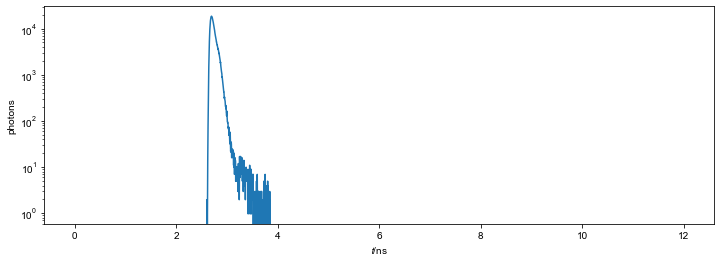

In [ ]:
irf = pc.load_sdt("calibration/IRF.sdt", dims="CXM", dtype=np.uint32)
fig, ax = plt.subplots(figsize=(12,4))
dc_kwargs_M1 = {
    "trunc": True,
    "peak_start": 2.6,
    "peak_end": 3.85,
    "bgsub": True,
    "bg_start": 8,
    "bg_end": 10,
    "fig": fig,
    "ax": ax
}
fig, ax, dc = pc.decay_curve(irf.sel(channel="M1"), plot=True, **dc_kwargs_M1)
plt.yscale("log")

irf

### The images are too large for some of the libraries I use for automated analysis. However, we only have 8 images so we can do this manually.

In [ ]:
sdt_conversion_list = pc.sdt_conversion_list(main_dir=Path(r"."), n_acqs_per_img=1,)
sdt_conversion_list = [Path(p) for p in np.array(sdt_conversion_list).flatten()]
sdt_conversion_list

[WindowsPath('dish1 control/img1.sdt'),
 WindowsPath('dish1 control/img2.sdt'),
 WindowsPath('dish1 control/img3.sdt'),
 WindowsPath('dish2 CCCP/img1.sdt'),
 WindowsPath('dish2 CCCP/img2.sdt'),
 WindowsPath('dish2 CCCP/img3.sdt'),
 WindowsPath('dish3 fasted/img1.sdt'),
 WindowsPath('dish3 fasted/img2.sdt')]

### I'll use the first image as an example. You can simply change the index in the cell below from 0 to 1, 2, ... 7 to analyze the remaining images.

In [ ]:
p = sdt_conversion_list[0]

In [ ]:
%%time

sdt = pc.load_sdt(p)
sdt

CPU times: total: 16.9 s
Wall time: 16.9 s


C:\Users\Arunachalam\anaconda3\envs\stardist_modern\lib\site-packages\dask\array\core.py:1519: RuntimeWarning: overflow encountered in long_scalars
  cbytes = format_bytes(np.prod(self.chunksize) * self.dtype.itemsize)


<xarray.DataArray (file_info: 1, channel: 2, y: 2048, x: 2048, microtime_ns: 256)>
dask.array<chunksize=(1, 1, 2048, 2048, 256), meta=np.ndarray>
Coordinates:
    filename          (file_info) <U8 dask.array<chunksize=(1,), meta=np.ndarray>
    parent_directory  (file_info) <U13 dask.array<chunksize=(1,), meta=np.ndarray>
    acqtime           (file_info) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    numscans          (file_info) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    laser_period      (file_info) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * channel           (channel) <U2 'M1' 'M2'
  * microtime_ns      (microtime_ns) float64 0.0 0.04684 0.09368 ... 11.9 11.94
Dimensions without coordinates: file_info, y, x

### The integrated intensity image (L) is not very clear, so we'll convolve with a Gaussian (M) before thresholding (R). The bright regions are mitochondria, and we'll try to capture these regions with the threshold. This is a fast, approximate method; one could use something more sophisticated and robust, like a random forest classifier or a neural network, which would use "texture" and similar information to do a better job at excluding cytoplasmic pixels. We'll save these images for reference.

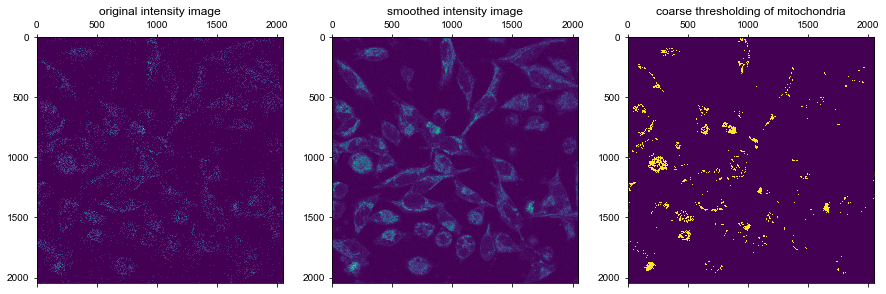

In [ ]:
int_im = pc.intensity_image(sdt).sel(channel="M1").squeeze().compute().data
blur_im = gaussian(int_im, sigma=2)
thresh_im = blur_im > 0.07

fig, ax = plt.subplots(figsize=(15,5), ncols=3)
ax[0].matshow(int_im)
ax[0].set_title("original intensity image")
ax[1].matshow(blur_im)
ax[1].set_title("smoothed intensity image");
ax[2].matshow(thresh_im)
ax[2].set_title("coarse thresholding of mitochondria")
plt.savefig(p.with_stem(p.stem + "_int_im").with_suffix(".png"), dpi=300, bbox_inches="tight");

### This is the corresponding decay curve. You have more than enough photons for FLIM analysis.

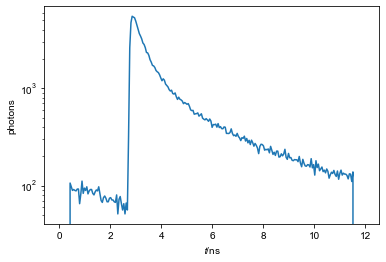

In [ ]:
pc.decay_curve(sdt.sel(channel="M1").squeeze(), mask=thresh_im, plot=True);

### We can fit this to a 2-exponential model: it is believed that short lifetime corresponds to free NAD(P)H, and long lifetime corresponds to enzyme-bound NAD(P)H. For a deeper look at the significance of these parameters, see e.g. https://elifesciences.org/articles/73808 .

### As you can see, a two-exponential fit is not perfect. In reality, multiple species (each with their own characteristic fluorescence decay lifetime) are likely contributing to the observed signal.

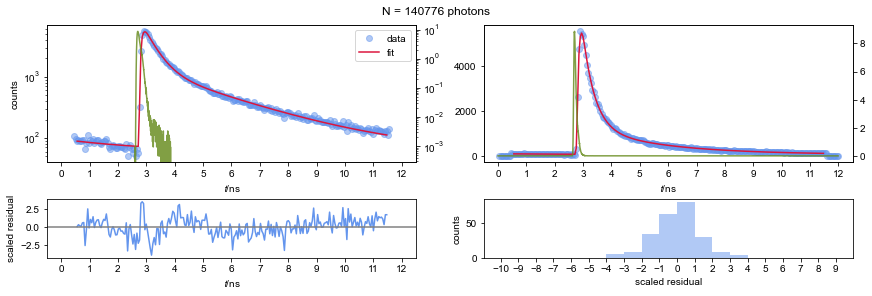

In [ ]:
dc = pc.decay_curve(sdt.sel(channel="M1").squeeze(), mask=thresh_im,).compute();
dg = pc.decay_group(
    dc,
    irf.sel(channel="M1"),
    irf_kws=dc_kwargs_M1,
)

fitp, status = dg.fit(
    model="2exp",
    fixed_parameters=[],
    save_leastsq_params_array=True,
    verbose=False,
    plot=True,
)

fitp_value = fitp["value"].to_dict()
fitp_err = fitp["err"].to_dict()

result = {
    "filename": str(p), 
    "photons_from": "mitochondria",
    "num_photons": dc.sum(),
    "intensity": dc.sum() / thresh_im.sum(),
    "fit_status": status,
    **fitp_value,
    **{item + "_err": fitp_err[item] for item in fitp_err},
}

In [ ]:
fitp

,value,err,min,max,step
shift,29.266208,0.341019,-200.00,200.0,1.000
A,0.991928,0.000991,0.70,1.0,0.001
tau1,2.665492,0.118415,1.00,9.0,0.001
tau2,0.408662,0.007575,0.01,1.0,0.001
f,0.178361,0.006210,0.01,1.0,0.001


### ...and here are the FLIM parameters. We have put these parameters, the intensity, the filename, and other information in a dictionary (`result`); we will then append this to a Pandas dataframe (`df_FLIM`). You can repeat this procedure for the other samples by simply changing (1) the filename and (2) adjusting the threshold to select mitochondria in each image. This threshold will likely vary from sample to sample based on treatment, focal plane, etc. (That is part of the motivation behind developing and testing more robust image segmentation methods as mentioned above.) Make sure not to rerun the cell right below this each time, because that will overwrite your dataframe. Alternatively, you can save the result from each sdt to a new Excel/CSV file, and combine them at the end.

In [ ]:
df_FLIM = pd.DataFrame()

In [ ]:
df_FLIM.append(result, ignore_index=True)

,filename,photons_from,num_photons,intensity,fit_status,shift,A,tau1,tau2,f,shift_err,A_err,tau1_err,tau2_err,f_err
0,dish1 control\img1.sdt,mitochondria,140776.0,1.530923,0.0,29.266208,0.991928,2.665492,0.408662,0.178361,0.341019,0.000991,0.118415,0.007575,0.00621
